# Introduction

The goal of this research is to develop a successful ML strategy in the context of the Forex market. This research focuses strictly on the USD/JPY currency, however, future research will take a much more broad approach, and strategies will be developed for a bevy of currencies. Research was conducted on USD/JPY tick data spanning from 2014-2018 and the best performing strategy was backtested on tick data from 2011-2013.

One of the primary inspirations for this research is the book Advances in Financial Machine Learning by Dr. Marcos Lopez de Prado. Dr. Lopez de Prado provides many code snippets throughout the book that are utilized in this project. I also made use of a library called mlfinlab, which has aggregated and expanded on much of the code in the book. Anytime a concept or code from Dr. Lopez de Prado or any source is used, it is stated as such.


# Data

The USD/JPY tick data used in this project was downloaded from TrueFx.com. This is the only source I am aware of that provides free historical tick data of any kind. The data includes the timestamp of the tick as well as the bid and ask price. Because Forex does not have a central exchange, volume data for each tick is not a part of the data set. As a result of this, data was sampled in tick bars, every 2800 ticks. The tick bars function in mlfinlab was used to sample the data. The function returns a DataFrame with open, high, low, and close prices for each tick. The motivation for using tick bars opposed to time bars is that tick bars exhibit a distribution of returns that is much closer to normal opposed to time bars. This is exhibited in the graph below:


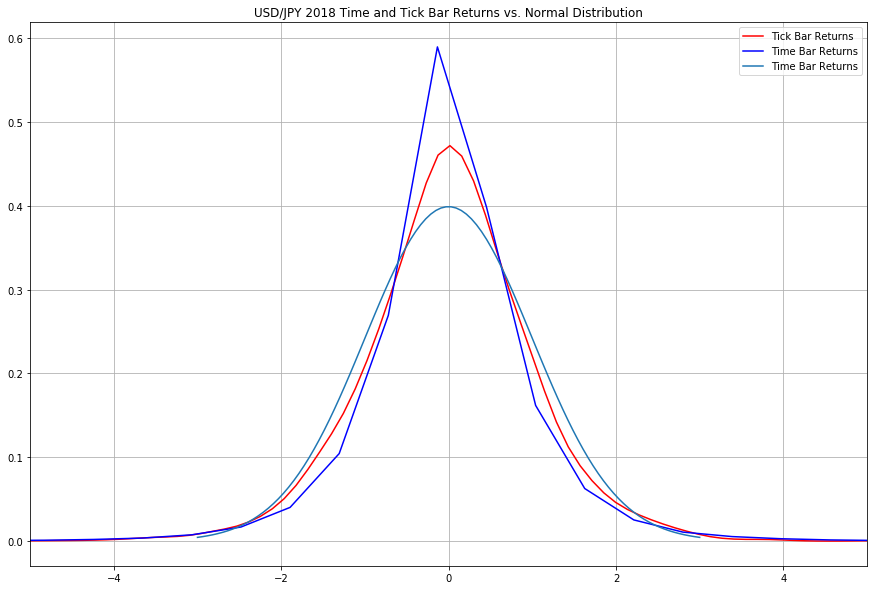

Tick bars also more realistically represent the market as trading frequency varies throughout the day. 

One of the drawbacks to sampling tick bars, however, is that sampling frequency is often very inconsistent throughout time. This is shown below:

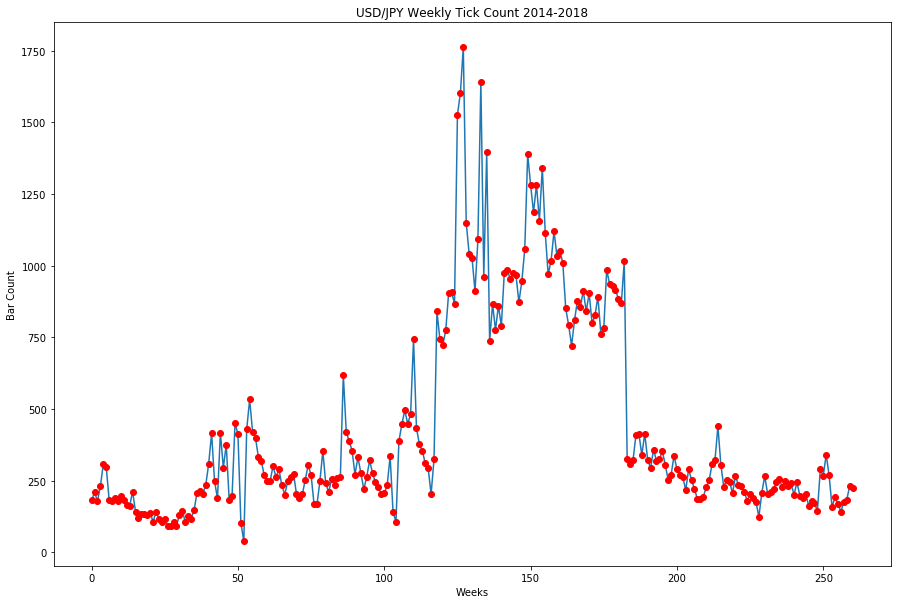

The sampling frequency when bars are sampled as a function of the volume traded or the dollar amount traded is much more consistent throughout time, however, both require volume data which was not available in this dataset.

In [2837]:
#Imports
import pandas as pd

import numpy as np

import seaborn as sns

import scipy
from scipy import stats

import mlfinlab as mlf
from mlfinlab.util import multiprocess

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection._split import _BaseKFold

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

import math

import empyrical

import talib

import multiprocessing as mp
from multiprocessing import cpu_count

from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense
from keras.layers import Dropout
from keras import Sequential
from keras import optimizers

In [ ]:
# Reading in feature matrix 
tick_bars = pd.read_csv('FILE_PATH',index_col=0, parse_dates=True)
ask = tick_bars['ask'].copy()
bid = tick_bars['bid'].copy()

# Feature Engineering

For the purposes of feature engineering as well as labeling, the mid-price of each tick was used, however, when it came to actually calculating the returns based on the predictions of the model, the bid and ask prices were used. 

The initial feature matrix included various technical analysis and signal processing features calculated at different time periods. The majority of these features were derived using the library ta-lib. The full list of initial features can be found [here](https://github.com/JackBrady/Financial-Machine-Learning-Research/blob/master/Forex%20Research/Initial_Feature_List). The inspiration for many of these features comes from their ubiquity in academic research pertaining to machine learning methods in the Forex market. Here are a few papers which make use of many of the aforementioned features:

Baasheer and Fakhr [2011] 
[link](http://www.wseas.us/e-library/conferences/2011/Penang/ACRE/ACRE-05.pdf) 
<br>
Abreu, Neves, and Horta [2018] 
[link](https://arxiv.org/pdf/1805.11232.pdf) 
<br>
Shahbazi, Memarzadeh, and Gryz [2016]
[link](https://www.matec-conferences.org/articles/matecconf/pdf/2016/31/matecconf_iciea2016_19001.pdf) 
<br>
Huang and Liu [2019]
[link](https://ideas.repec.org/a/eco/journ1/2019-02-23.html)

Additionally, 7 fractionally differentiated features were generated. Fractionally differentiated features are a concept presented by Dr. Lopez de Prado. The idea is that when a price series is differentiated to calculate log returns, we lose all memory of the underlying series in an effort to achieve stationarity. Prices, in contrast to returns have memory, however, are not stationary. Dr. Lopez de Prado proposes a method to difference a price series to achieve stationarity, without fully differencing the series and thereby losing all memory. The motivation being that conserving memory will yield more predictive power. This fracationally differentiated series can then be used as a feature. 

In [2906]:
plotMinFFD(tick_bars,'close')

,adfStat,pVal,lags,nObs,95% conf,corr
0.0,-2.106910,2.417452e-01,1.0,1318.0,-2.863735,1.000000
0.1,-2.393264,1.436467e-01,1.0,1313.0,-2.863744,0.999334
0.2,-2.909197,4.428895e-02,1.0,1310.0,-2.863749,0.994632
0.3,-3.897853,2.050704e-03,1.0,1310.0,-2.863749,0.980985
0.4,-5.199077,8.830312e-06,1.0,1310.0,-2.863749,0.955427
0.5,-7.049648,5.569259e-10,1.0,1311.0,-2.863747,0.907075
0.6,-9.608250,1.841198e-16,1.0,1312.0,-2.863745,0.822383
0.7,-12.281292,8.212373e-23,1.0,1314.0,-2.863742,0.728096
0.8,-16.363358,2.856350e-29,1.0,1315.0,-2.863740,0.557746
0.9,-20.075835,0.000000e+00,1.0,1315.0,-2.863740,0.407113


Here we can see that differencing our USD/JPY price series by 0.2 achieves stationarity, p < 0.05, while still having a very strong correlation to the original price series. The function for plotting the minumum amount of differencing needed to achieve stationarity as well as the functions to actual calculate the fractionally differntiated features are provided by Dr. Lopez de Prado and can be found [here](https://github.com/JackBrady/Financial-Machine-Learning-Research/blob/master/Forex%20Research/Code/Fractionally_Differentiated_Features.py).

While the inital feature matrix consisted of 57 features, our final feature matrix contained 31 features that were selected using two feature selection methods as well as by testing various subsets of features. These feature selection methods are discusseed below.

# Feature Selection

Two feature selection methods were used to generate the final set of features. The first method was mean decrease impurity (MDI), a tree based method, which calculates how much each individual feature decreases the overall impurity. The functions to calculate and plot feature importance based on MDI were provided by Dr. Lopez de Prado and were used to generate the figure below. This plot shows the feature importance for the initial set of 57 features. The code for each function can be found [here](https://github.com/JackBrady/Financial-Machine-Learning-Research/blob/master/Forex%20Research/Code/Feature_Importance.py).


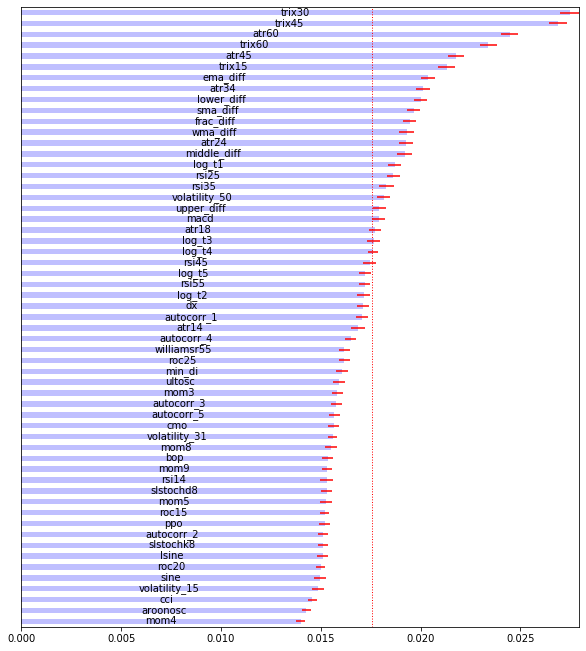

The second method used is an input perturbation feature ranking algorithm proposed originally by Dr. Leo Breiman and demonstrated by Dr. Jeff Heaton in the following video: [link](https://www.youtube.com/watch?v=RVIGVkj5aXo&t=1105s)

The idea behind this method is that a feature's column is shuffled, and the accuracy of the model is then re-evaluted with the shuffled column. The significance of decrease in model accuracy with the shuffled column determines the respective feature's importance.

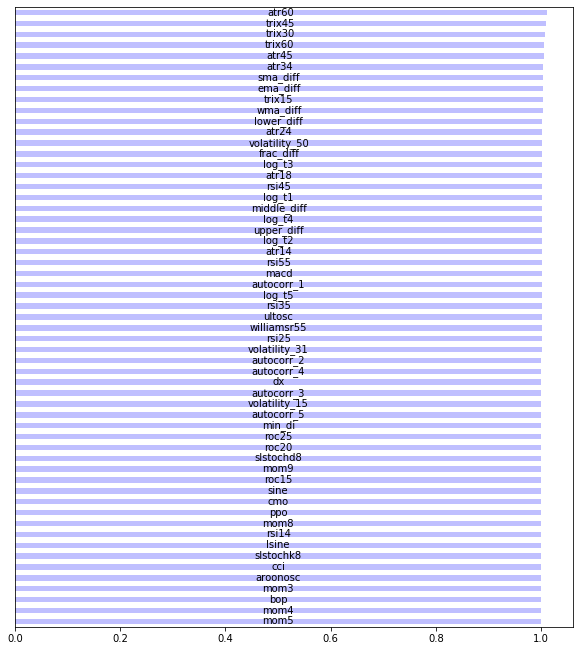

The correlation between the rankings of the feature selection methods is very high, however, in this case MDI does a much better job of showing the degree to which features differ in their respective importance.

In [322]:
pert_rank['importance'].corr(mdi_p['mean'])

0.939444276368361

The list of the final 31 features used can be found [here](https://github.com/JackBrady/Financial-Machine-Learning-Research/blob/master/Forex%20Research/Final_Feature_List).

# Downsampling

The tick bars sampled previously were downsampled using the CUSUM filter provided by Dr. Lopez de Prado, which, as stated by Dr. Lopez de Prado,  is "designed to detect a shift in the mean value of a measured quantity away from a target value.”  The intuition is that we want to make a prediction on an observation after a certain threshold is reached opposed to just predicting at a random point in time. In our case a bar was sampled if the cumulative sums of the price differences in either direction surpassed 1/10 the mean daily volatility. The CUSUM filter supplied by mlfinlab was utilized below:

In [2844]:
closing = tick_bars['close']
volatility = get_daily_volatility(closing)
times = mlf.filters.cusum_filter(closing, volatility.mean()*.1)

Additionally, the get_daily_volatility function was provided by Dr. Lopez de Prado, and is available [here](https://github.com/JackBrady/Financial-Machine-Learning-Research/blob/master/Forex%20Research/Code/Utility_Functions.py).

# Labeling

Instead of labeling observations based on the sign of their returns after a given amount of time, observations are given a label based on whether or not they reached reached a return that is based on their respective volatilities. This allows for observations with more risk to have a higher expected return and vice versa. If an observations does not reach its expected return in a predetermined amount of time, it is given a label of 0, representing a return that is too low for us to make a bet on. If it reaches its return in the positive direction (upper barrier), a label of 1 is given, representing a long position. If it reaches its return in the negative direction (lower barrier), a label of -1 is given, representing a short position. This concept was presented by Dr. Lopez de Prado, and is known as the triple-barrier method, as we have a vertical (time) barrier and a horizontal barrier for long and short positions.

As stated previously, the mid-price of each tick was used for labeling observations.

mlfinlab was utilized for the following labeling functions. Additionally, Dr. Lopez de Prado provides a multiprocessing engine to speed up computation, which was made us of in the get_events function.

In [ ]:
# 1 day was the amount of time set for the vertical barrier
# The minimum return for an observation to be considered was set to 0.004
# The upper and lower barrier were not scaled
vertical_barriers = mlf.labeling.add_vertical_barrier(times, closing, num_days=1)
pt_sl = [1,1]
min_ret = 0.004
threads = cpu_count()-1

In [ ]:
triple_barrier_events = mlf.labeling.get_events(closing,
                                               times,
                                               pt_sl,
                                               volatility,
                                               min_ret,
                                               threads,
                                               vertical_barriers)

In [ ]:
labels_one = mlf.labeling.get_bins(triple_barrier_events, closing)

In [35]:
labels_one['bin'].value_counts()

 0    6672
 1    5290
-1    5056
Name: bin, dtype: int64

# Model Architecture

The model architecture used in this project is based on the concept of meta-labeling formulated by Dr. Lopez de Prado. The idea behind meta-labeling is that we have a primary and a secondary binary classifier. The primary classifier predicts the side of the bet (-1,1), while the secondary classifier predicts whether or not we want to take the bet (0,1). It has been shown previously how labels are derived for the primary classifer, however, the labels derived for the secondary classifier, i.e. meta-labels, are obtained using a modified version of the get_events function which takes in the side predicted by the primary classifier. 

For example, if our primary classifier predicts a 1 for an observation, but the actual label is a -1, then this observation will receive a meta-label of 0, and the secondary classifer will be trained to predict a 0. Additionally, it can be seen previously that many observations did not reach their target return and thus received a label of 0. If this is the case, these observations will also receive a meta-label of 0. A meta-label of 1 is only given when the primary classifier's prediction is accurate.

The motivation for this technique is that the secondary classifier can learn from the error of the primary classifier, allowing it to act as a filter for bets.

Additionally, one of the primary use cases of meta-labeling is for bet sizing, i.e. we can use the predicted probability of the secondary classifier to determine the size of the bet for a given observation. While bet sizing was not implemented, it will be a focal point of future research. 

Though meta-labeling is a technique made use of in this research, the objective of this project is not to demonstrate its utility in comparison to traditional labeling techniques. For an example of the effectiveness of meta-labeling in the context of classification on the MNIST dataset, please see: [link](https://github.com/hudson-and-thames/research/blob/master/Chapter3/2019-03-06_JJ_Meta-Labels-MNIST.ipynb)

# Training Data

The observations that intially received a label of 0, i.e. they did not reach their target return in time, were not used to train the primary model, however, they were used to train the secondary model. The motivation for this is that training the primary model to recognize observations that will ideally receive a prediction of 0 from the secondary model, regardless of the primary model's prediciton, does not seem to be worthwhile. The full training process then goes as follows:

The primary model is trained on observations receiving a label of -1 or 1. 
Then, the observations receiving a label of 0 are aggregated with the training data. 
This full set of observations is then passed through the trained primary model and meta-labels are derived on these predictions. 
The secondary model is then trained using the same features as the primary model with the predicted side of the primary model being an additional feature. 

The following code prepares our data for training. Future work will make use of sklearn's pipeline class as separately standardizing the data is quite tedious. 

In [ ]:
# Full DataFrame including all observations regardless of label
full_df = pd.DataFrame(tick_bars.loc[labels_one['bin'].index], index=labels_one['bin'].index)
full_df.drop(columns=['open','high','close','low','bid','ask'],inplace=True)
full_df['labels'] = labels_one['bin'].copy()
y = full_df['labels'].copy()
full_df.drop(columns=['labels'],inplace=True)
x = full_df.copy()

In [ ]:
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(x, y, test_size=0.20,
                                                                        shuffle=False)

In [ ]:
# Start and end times for an observation
t1 = triple_barrier_events['t1'].copy()

In [ ]:
#training observations purged. This will be discussed in the next section
train_i = t1.loc[X_train_full.index]
test_i = t1.loc[X_test_full.index]
train_times = getTrainTimes(train_i,test_i)

It should be noted that while the test data for the primary model does not contain any observations with a label of 0, the test data being used for the secondary model is an aggregation of all test data regardless of label. Additonally, if the training set was transformed in any way, the same scaling was applied to the testing set.

In [ ]:
X_train_full = X_train_full.loc[train_times.index]
y_train_full = y_train_full.loc[train_times.index]

# Getting a feature matrix for observations with labels -1 and 1

X_train = X_train_full[y_train_full != 0].copy()

# Getting a feature matrix for observations with label 0
X_train_addit = X_train_full[y_train_full == 0].copy()

y_train = y_train_full.loc[X_train.index].copy()

X_test = X_test_full[y_test_full != 0].copy()

y_test = y_test_full.loc[X_test.index].copy()

X = pd.concat([X_train,X_test])
y = pd.concat([y_train,y_test])

In [ ]:
#Standardizing the data
scaler = StandardScaler()
new_training = scaler.fit_transform(X_train)

new_testing = scaler.transform(X_test)

new_testing_full = scaler.transform(X_test_full)

X_train_stand = pd.DataFrame(new_training,index=X_train.index)
X_test_stand = pd.DataFrame(new_testing,index=X_test.index)
X_test_stand_full = pd.DataFrame(new_testing_full,index=X_test_full.index)

scaler = StandardScaler()
full_stand = scaler.fit_transform(X)

In [ ]:
'''
This standardizes the observations with a label of 0 separately from the primary model's training set. 
These observations will not be used for training the primary model.
They will be aggregated with the original training set post-training and the full output will be fed to the
secondary model.
'''

scaler_addit = StandardScaler()
new_training_addit = scaler_addit.fit_transform(X_train_addit)
X_train_addit_stand = pd.DataFrame(new_training_addit,index=X_train_addit.index)
X_train_stand_full = pd.concat([X_train_stand,X_train_addit_stand])

# Sample Weights

Observations are weighted as a function of their respective uniqueness. An observation is deemed completely unique if the time interval used to generate its label has no overlap with the time interval used to generate the label of another observation. The more overlap an observation has and the longer those overlaps last, the less unique the observation is. Additionally, a linear time-decay is applied to the sample weights, giving older observations less importance. This method for calculating sample weights was proposed by Dr. Lopez de Prado as well as the method for calculating the uniqueness of an observation. 



The following function calls many of the functions provided by Dr. Lopez de Prado and returns sample weights 
as well as the average uniqueness across all observations. It also makes use of the multiproccessing engine mentioned previously. Code for these functions can be found: [here](https://github.com/JackBrady/Financial-Machine-Learning-Research/blob/master/Forex%20Research/Code/Sample_Weights.py) 
                            


In [ ]:
training_weights = get_weights_and_avgu(closing,X_train,threads,t1)[1]

In [ ]:
avgu,sample_weights = get_weights_and_avgu(closing,X,threads,t1) 

In the previous section, observations were removed from the training set if the time interval used for generating their labels had any overlap with the observations in the testing set. This technique, proposed by Dr. Lopez de Prado, is known as "purging" and aims at removing any sort of leakage between the train and test set. Code provided by Dr. Lopez de Prado for purging the training set can be found: [here](https://github.com/JackBrady/Financial-Machine-Learning-Research/blob/master/Forex%20Research/Code/Cross_Validation.py)

# Model Selection

Three different models were used for the primary classifier in this research:
<br>
The first model was a bagged decision tree.
<br>
The second was a bagged SVM.
<br>
The third was an ANN.

The reason I used bagged decsion trees opposed to sklearn's random forest classifier was due to severe overfitting issues I was having with the traditional random forest model. This is very likely a result of observational redundancy in our training set, i.e. many overlapping outcomes. To mitigate the issue of redundnacy, Dr. Lopez de Prado recommended using a bagging classifer and setting the max_samples parameter to the average uniqueness of our observations, which helps prevent the creation of many redundant trees. While the bagging classifier supports the max_samples parameter, it is not supported in sklearn's random forest classifier.

The initial plan was to use these three models as both primary and secondary classifiers and to test every combination of models yielding 9 potential combinations. As secondary classifiers, however, the bagged SVM and ANN were severely overpredicting the majority class even after adding class weights, upsampling the minority class, and attempting to tune hyperparameters using f1 as the scoring metric. Because of these issues, the bagged decision tree was the only model used as a secondary classifier.

# Other Tested Architectures

I additionally attempted to implement model stacking for the primary classifier, however, I did not see any improvement in accuracy. This is most likely due to redundant predictions between the three classifier or poor choice for the "meta-learner". In the future, the decison to use model stacking will be made beforehand as selecting diverse models is a necessary criteria for its effectiveness. The ensembling library, mlens, provides a high-performance architecture for model stacking and will be utilized in future work. 

# Feature Extraction

PCA was the only feature extraction technique used and showed improvement in accuracy for the primary bagged decsion tree classifier. A function to calculate the the mimimum number of orthogonal features which account for 95% of the variance of the standardized feature matrix was provided by Dr. Lopez de Prado. This function was utilized to calculate the number of principal components to be used, which was found to be 7. The number of principal components are often treated as a hyperparameter and tuned accordingly, however, in this research the aforementioned function was used instead. Code for this function can be found [here](https://github.com/JackBrady/Financial-Machine-Learning-Research/blob/master/Forex%20Research/Code/Feature_Extraction.py).

Additionally, I tried the class-based PCA technique proposed in the following paper: Baasheer and Fakhr [2011] 
[link](http://www.wseas.us/e-library/conferences/2011/Penang/ACRE/ACRE-05.pdf), however, I did not see any improvement in accuracy and decided not to go further with the method.

In [2862]:
pc = orthoFeats(X_train)
num_feat = pc.shape[1]

In [2885]:
scaler = StandardScaler()
new_training = scaler.fit_transform(X_train)

new_testing = scaler.transform(X_test)
new_testing_full = scaler.transform(X_test_full)

pca = PCA(n_components=num_feat)
X_train_pca = pca.fit_transform(new_training)
X_test_pca = pca.transform(new_testing)
X_test_full_pca = pca.transform(new_testing_full)

pca_addit = PCA(n_components=num_feat)
X_train_addit_pca = pca_addit.fit_transform(X_train_addit)

X_train_pca_df = pd.DataFrame(X_train_pca,index=X_train.index)
X_train_addit_pca_df = pd.DataFrame(X_train_addit_pca,index=X_train_addit.index)

X_train_full_pca = pd.concat([X_train_pca_df,X_train_addit_pca_df])
X_test_full_pca_df = pd.DataFrame(X_test_full_pca,index=X_test_full.index)

scaler_full = StandardScaler()
full_scaled = scaler.fit_transform(X)
full = PCA(n_components=num_feat)
full_pca = full.fit_transform(full_scaled)

# Primary Model Training/Hyperparameter Tuning

In [2860]:

dt=DecisionTreeClassifier(criterion='entropy',max_features='auto',
                          class_weight='balanced',min_weight_fraction_leaf=0.05,random_state=20)

bagged_dt=BaggingClassifier(base_estimator=dt,n_estimators=1000,max_samples=avgu,
                            max_features=1.,random_state=20)


In [2864]:
bagged_dt.fit(X_train_pca,y_train,sample_weight=training_weights)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                        criterion='entropy',
                                                        max_depth=None,
                                                        max_features='auto',
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.05,
                                                        presort=False,
                                                        random_state=20,
                                                        splitter='be

I was having issues tuning the hyperparameters of the bagged SVM, as the tuned model would consistently predict every observation in one class. Regardless of which scoring metric I used or whether I used grid search or random search with a uniform or log-uniform distribution, I still had this issue. Because of this, the default parameters for C and gamma were used.

In [ ]:
svc = SVC(probability=True,gamma='auto',random_state=20)

SVC_bagged=BaggingClassifier(base_estimator=svc,n_estimators=1000,max_samples=avgu,
                                   random_state=20,max_features=1.)

In [106]:
SVC_bagged.fit(X_train_stand,y_train,sample_weight=training_weights)

BaggingClassifier(base_estimator=SVC(C=1.0, cache_size=200, class_weight=None,
                                     coef0=0.0, decision_function_shape='ovr',
                                     degree=3, gamma='auto', kernel='rbf',
                                     max_iter=-1, probability=True,
                                     random_state=20, shrinking=True, tol=0.001,
                                     verbose=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=0.07594124165785086, n_estimators=1000,
                  n_jobs=None, oob_score=False, random_state=20, verbose=0,
                  warm_start=False)

Many of the hyperparamters in this ANN were found by trial and error. Ideally, we would tune every potential hyperparameter at once, however, I don't currently have the compute resources at my disposal to make that feasible. Anything past two hidden layers began to overfit. Additionally, past 200 epochs began to overfit. The number of neurons was initally tuned along with the learning rate, however, 8 neurons was consistently chosen as the best parameter.

In [2213]:
def build_ann(input_size,lr,classes):
    from numpy.random import seed
    seed(1)
    from tensorflow import set_random_seed
    set_random_seed(2)
    
    model = Sequential()
    model.add(Dense(8,input_dim=input_size,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8))
    model.add(Dropout(0.2))
    model.add(Dense(classes,activation='softmax'))
    optimizer = optimizers.adam(lr)
    model.compile(loss='categorical_crossentropy',optimizer=optimizer)
    return model

ANN = KerasClassifier(build_fn=build_ann,input_size=X_train_stand.shape[1],classes=2)

# Hyperparameter Tuning (Grid Search)

As stated previously, observations from the training set that overlap the testing set must be purged. This is also necessary in k-fold cross validation, where we have potential overlap on both sides of the test set. The purged k-fold class, provided by Dr. Lopez Prado [link](https://github.com/JackBrady/Financial-Machine-Learning-Research/blob/master/Forex%20Research/Code/Cross_Validation.py), is implemented in the hyperparamter tuning function below. This function makes use of sklearn's GridSearchCV, however, instead of traditional k-fold cross validation, purged k-fold cross validation is used. 


In [ ]:
param_grid={'epochs':[200],'lr':[0.00001,0.0001,0.001,0.01,.1]}

t1cv = t1.loc[X_train_stand.index].copy()
tuned_ANN = clfHyperFitnn(X_train_stand,y_train,t1cv,ANN,param_grid,training_weights,cv=5)
tuned_ANN = tuned_ANN.best_estimator_

In [2074]:
tuned_ANN.sk_params

{'input_size': 31, 'classes': 2, 'epochs': 200, 'lr': 0.0001}

The hyperparameter tuning function used previously to tune the learning rate is a modified version of Dr. Lopez de Prado's and can be found [here](https://github.com/JackBrady/Financial-Machine-Learning-Research/blob/master/Forex%20Research/Code/Hyperparameter_Tuning.py).

# Primary Model Results

The results from the test set for each primary classifier are aggregated in the DataFrame below, however, if one wishes to view the code and output for the classification reports, ROC curve, and CV score for each model, it is also available below.

In [340]:
primary_res_df

,Accuracy,CV Score,AUC
Bagged DT,57%,55.51%,.65
Bagged SVM,53%,53.90%,.65
ANN,59%,54.18%,.67


# Primary Classifier: Bagged Decision Trees

# Training Data

In [90]:
y_pred = bagged_dt.predict(X_train_pca)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          -1       0.61      0.57      0.59      3974
           1       0.63      0.67      0.65      4415

    accuracy                           0.62      8389
   macro avg       0.62      0.62      0.62      8389
weighted avg       0.62      0.62      0.62      8389



# Test Data

In [91]:
y_pred2 = bagged_dt.predict(X_test_pca)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

          -1       0.66      0.47      0.55      1054
           1       0.52      0.70      0.60       875

    accuracy                           0.57      1929
   macro avg       0.59      0.59      0.57      1929
weighted avg       0.60      0.57      0.57      1929



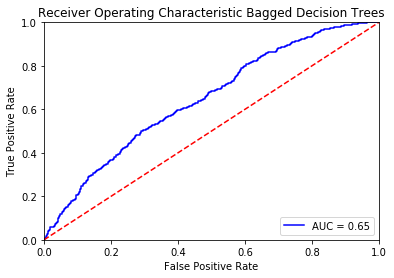

# Mean CV Score on Full Data Set 
(Metric: Accuracy)

The cvScore function was provided by Dr. Lopez de Prado and also makes use of the purged k-fold class. Code for this function can be found [here](https://github.com/JackBrady/Financial-Machine-Learning-Research/blob/master/Forex%20Research/Code/Cross_Validation.py).

In [96]:
y = y.loc[X.index].copy()
sample_weights = get_weights_and_avgu(closing,X,threads,t1)[1]
vert_barr = t1.loc[X.index].copy()
full_pca_df = pd.DataFrame(full_pca,index=X.index)

scores = cvScore(bagged_dt,full_pca_df,y,sample_weights,scoring='accuracy',
                 t1=vert_barr,cv=10,pctEmbargo=0.01)

2019-07-09 19:06:38.891275 100.0% mpNumCoEvents done after 0.03 minutes. Remaining 0.0 minutes..
2019-07-09 19:06:40.387380 100.0% mpSampleTW done after 0.02 minutes. Remaining 0.0 minutes..
2019-07-09 19:06:42.476432 100.0% mpSampleW done after 0.03 minutes. Remaining 0.0 minutes..


In [97]:
scores.mean()

0.5551425632320195

# Primary Classifier: Bagged SVM

# Training Data

In [107]:
y_pred = SVC_bagged.predict(X_train_stand)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          -1       0.63      0.47      0.54      3974
           1       0.61      0.75      0.68      4415

    accuracy                           0.62      8389
   macro avg       0.62      0.61      0.61      8389
weighted avg       0.62      0.62      0.61      8389



# Test Data

In [108]:
y_pred = SVC_bagged.predict(X_test_stand)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.77      0.20      0.31      1054
           1       0.49      0.93      0.64       875

    accuracy                           0.53      1929
   macro avg       0.63      0.56      0.48      1929
weighted avg       0.64      0.53      0.46      1929



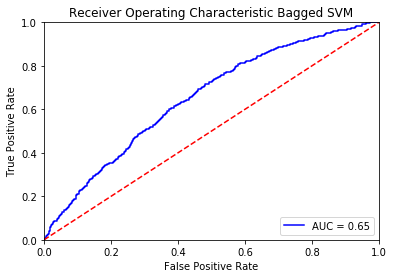

# Mean CV Score on Full Data Set 
(Metric: Accuracy)

In [110]:
full_stand_df = pd.DataFrame(full_stand,index=X.index)

scores = cvScore(SVC_bagged,full_stand_df,y,sample_weights,scoring='accuracy',
                 t1=vert_barr,cv=10,pctEmbargo=0.01)

In [111]:
scores.mean()

0.53904931652846

# Primary Classifier: ANN

# Training Data

In [333]:
y_pred = tuned_ANN.predict(X_train_stand)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          -1       0.62      0.44      0.52      3974
           1       0.60      0.76      0.67      4415

    accuracy                           0.61      8389
   macro avg       0.61      0.60      0.59      8389
weighted avg       0.61      0.61      0.60      8389



# Test Data

In [334]:
y_pred = tuned_ANN.predict(X_test_stand)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.74      0.38      0.50      1054
           1       0.53      0.84      0.65       875

    accuracy                           0.59      1929
   macro avg       0.63      0.61      0.57      1929
weighted avg       0.64      0.59      0.57      1929



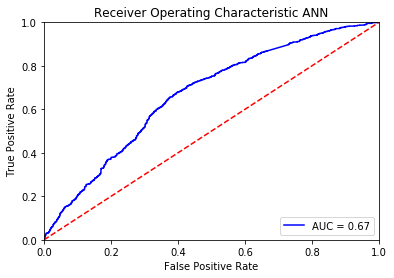

# Mean CV Score on Full Data Set 
(Metric: Accuracy)

In [ ]:
scores = cvScorenn(tuned_ANN,full_stand_df,y,sample_weights,200,scoring='accuracy',
                   t1=vert_barr,cv=10,pctEmbargo=0.01)

In [338]:
scores.mean()

0.5417619537833829

# Primary/Secondary Model Training Data

The code for preparing data for the secondary model is shown below. The get_events function used previously is used once more, this time taking in the side predicted by the primary model in order to generate the meta-labels. Additionally, the prediction from the primary model is used as a feature for the secondary model. The following code is for the ANN as the primary classifier, however, the process is the same regardless of which model gave the predictions.

In [341]:
y_pred_full = tuned_ANN.predict(X_train_stand_full)
primary_l = y_pred_full.copy()

In [342]:
y_pred_full_test = tuned_ANN.predict(X_test_stand_full)
primary_l_test = y_pred_full_test.copy()

In [344]:
side_train = pd.DataFrame(primary_l.copy(),index=X_train_stand_full.index)
side_test = pd.DataFrame(primary_l_test.copy(),index=X_test_stand_full.index)
side = pd.concat([side_train,side_test])
side.sort_index(inplace=True)

In [346]:
times = side.index
vertical_barriers = vertical_barriers.loc[side.index]
pt_sl = [1,1]
min_ret = 0.004
threads = cpu_count()-1

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [347]:
triple_barrier_events = mlf.labeling.get_events(closing,
                                               times,
                                               pt_sl,
                                               volatility,
                                               min_ret,
                                               threads,
                                               vertical_barriers,
                                               side[0])

2019-07-09 23:13:31.133115 100.0% apply_pt_sl_on_t1 done after 0.16 minutes. Remaining 0.0 minutes.


In [348]:
labels = mlf.labeling.get_bins(triple_barrier_events, closing)

In [349]:
labels['bin'].value_counts()

0    10636
1     6293
Name: bin, dtype: int64

In [350]:
t1 = triple_barrier_events['t1'].copy()

In [381]:
new_y_train = labels['bin'].loc[X_train_full_pca.index].copy()
new_x_train = tick_bars.loc[X_train_full_pca.index].copy()

new_y_test = labels['bin'].loc[X_test_full_pca.index].copy()
new_x_test = tick_bars.loc[X_test_full_pca.index].copy()

In [382]:
new_x_train.dropna(inplace=True)
new_x_train.drop(columns=['open','high','close','low','volume','bid','ask'],inplace=True)

new_x_test.dropna(inplace=True)
new_x_test.drop(columns=['open','high','close','low','volume','bid','ask'],inplace=True)

In [383]:
new_x_train['predicted_side'] = side[0].loc[new_x_train.index].copy()
new_x_test['predicted_side'] = side[0].loc[new_x_test.index].copy()

In [384]:
new_x_train.sort_index(inplace=True)
new_y_train.sort_index(inplace=True)
new_x_test.sort_index(inplace=True)
new_y_test.sort_index(inplace=True)

In [386]:
full_new_x = pd.concat([new_x_train,new_x_test]).copy()
full_new_y = pd.concat([new_y_train,new_y_test]).copy()

In [385]:
avgmu,training_weights_meta = get_weights_and_avgu(closing,new_x_train,threads,t1)

2019-07-09 23:27:07.237051 100.0% mpNumCoEvents done after 0.04 minutes. Remaining 0.0 minutes..
2019-07-09 23:27:09.044871 100.0% mpSampleTW done after 0.03 minutes. Remaining 0.0 minutes..
2019-07-09 23:27:11.590055 100.0% mpSampleW done after 0.04 minutes. Remaining 0.0 minutes..


In [387]:
sample_weights_meta = get_weights_and_avgu(closing,full_new_x,threads,t1)[1]

2019-07-09 23:27:16.134619 100.0% mpNumCoEvents done after 0.05 minutes. Remaining 0.0 minutes..
2019-07-09 23:27:18.458274 100.0% mpSampleTW done after 0.04 minutes. Remaining 0.0 minutes..
2019-07-09 23:27:21.616161 100.0% mpSampleW done after 0.05 minutes. Remaining 0.0 minutes..


# Primary/Secondary Model Training

In [388]:
dt_meta=DecisionTreeClassifier(criterion='entropy',max_features='auto',
                               class_weight='balanced',min_weight_fraction_leaf=0.05,random_state=20)

bagged_dt_meta=BaggingClassifier(base_estimator=dt_meta,n_estimators=1000,
                                 max_samples=avgmu,max_features=1.,random_state=20)

bagged_dt_meta.fit(new_x_train,new_y_train,sample_weight=training_weights_meta)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                        criterion='entropy',
                                                        max_depth=None,
                                                        max_features='auto',
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.05,
                                                        presort=False,
                                                        random_state=20,
                                                        splitter='be

# Primary/Secondary Model Results

The aggregated results from the test set for the three model combinations can be seen in the following DataFrame. The code and output for the results are also available below.

In [377]:
secondary_res_df

,Accuracy,CV Score,AUC
Bagged DT/Bagged DT,52%,54.78%,.55
Bagged SVM/Bagged DT,56%,55.78%,.59
ANN/Bagged DT,53%,54.10%,.56


# Performance and Risk Metrics

The metrics used to evaluate the success and risk of a model were: the Sharpe Ratio, cumulative returns, max drawdown, and percentage normalized profit (PNP). The function I wrote for PNP is inspired by the following paper: Baasheer and Fakhr [2011] [link](http://www.wseas.us/e-library/conferences/2011/Penang/ACRE/ACRE-05.pdf), and calculates the percentage of return we achieved out of the total return we could have acheived, had we predicted everything correctly in the test set. 

It should be stated that PNP is not a perfect metric for evaluating our model's profit versus the ideal profit because a bet that didn't reach its return should be classified as a 0, however, let's say that our secondary model misclassifies the bet as a 1 and the actual sign of the return was classified correctly by our primary model. This would present a situation where misclassification gained some profit that the ideal model could not have also gained. Regardless, PNP is still a useful metric in evaluating the profit of the secondary model given the primary model's predictions.

The code for the PNP function can be found [here](https://github.com/JackBrady/Financial-Machine-Learning-Research/blob/master/Forex%20Research/Code/Backtest.py). Please note that the returns calculated for this function are non-cumulative.

Additionally, the function for calculating returns using the bid and ask prices can be found in the previous link.


The DataFrame for our performance and risk metrics can be seen below. Additionally, it must be noted that our returns do exhibit significant serial correlation. I partitioned the returns series into less correlated subsets, but did not notice any signicant change in the Sharpe Ratio estimate when calculated on these subsets. It still must be noted, however, that the Sharpe Ratio will be inflated as a result of this serial correlation.

In [379]:
performance_risk_met_df

,PNP,Cumulative Returns,Sharpe Ratio,Max Drawdown
Bagged DT/Bagged DT,28.88%,459.9%,3.61,-41.8%
Bagged SVM/Bagged DT,37.65%,789.92%,4.77,-38%
ANN/Bagged DT,30.38%,480.49%,3.73,-34.36%


# Primary Classifier: Bagged Decision Trees
# Secondary Classifier: Bagged Decision Trees


# Training Data

In [162]:
y_pred = bagged_dt_meta.predict(new_x_train)
print(classification_report(new_y_train, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.71      0.71      8452
           1       0.52      0.53      0.53      5073

    accuracy                           0.64     13525
   macro avg       0.62      0.62      0.62     13525
weighted avg       0.64      0.64      0.64     13525



# Test Data


In [163]:
y_pred = bagged_dt_meta.predict(new_x_test)
print(classification_report(new_y_test, y_pred))
filt = y_pred.copy()

              precision    recall  f1-score   support

           0       0.68      0.49      0.57      2223
           1       0.37      0.57      0.45      1181

    accuracy                           0.52      3404
   macro avg       0.53      0.53      0.51      3404
weighted avg       0.58      0.52      0.53      3404



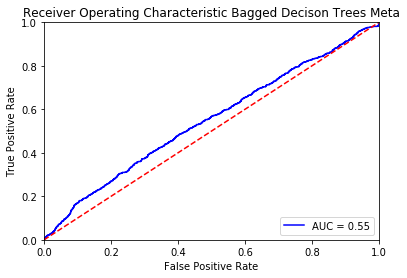

# Mean CV Score on Full Data Set 
(Metric: Accuracy)

In [194]:
vert_barr = t1.loc[full_new_x.index].copy()
scores = cvScore(bagged_dt_meta,full_new_x,full_new_y,sample_weights_meta,scoring='accuracy',
                 t1=vert_barr,cv=10,pctEmbargo=0.01)

In [195]:
scores.mean()

0.5477632142485878

# Performance and Risk Metrics

In [177]:
percentage_normalized_profit(new_y_test,new_x_test,labels_one,side,t1,bid,ask,filt)

0.2888114013898721

In [178]:
bag_bag_ret = returns_series(new_x_test,side,t1,bid,ask,filt)

In [180]:
np.around(empyrical.stats.cum_returns(bag_bag_ret).iloc[-1]*100, 2)

459.9

In [181]:
np.around(empyrical.stats.sharpe_ratio(bag_bag_ret),2)

3.61

In [182]:
np.around(empyrical.stats.max_drawdown(bag_bag_ret)*100,2)

-41.8

# Primary Classifier: Bagged SVM
# Secondary Classifier: Bagged Decision Trees


# Training Data

In [227]:
y_pred = bagged_dt_meta.predict(new_x_train)
print(classification_report(new_y_train, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.73      0.72      8388
           1       0.54      0.52      0.53      5137

    accuracy                           0.65     13525
   macro avg       0.63      0.63      0.63     13525
weighted avg       0.65      0.65      0.65     13525



# Test Data


In [228]:
y_pred = bagged_dt_meta.predict(new_x_test)
print(classification_report(new_y_test, y_pred))
filt = y_pred.copy()

              precision    recall  f1-score   support

           0       0.74      0.53      0.61      2262
           1       0.40      0.63      0.49      1142

    accuracy                           0.56      3404
   macro avg       0.57      0.58      0.55      3404
weighted avg       0.62      0.56      0.57      3404



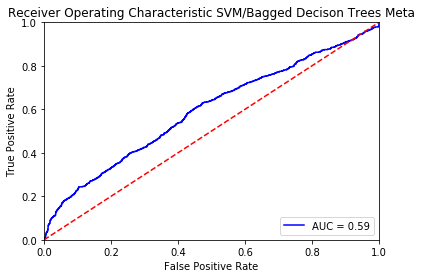

# Mean CV Score on Full Data Set 
(Metric: Accuracy)

In [250]:
scores = cvScore(bagged_dt_meta,full_new_x,full_new_y,sample_weights_meta,scoring='accuracy',
                 t1=vert_barr,cv=10,pctEmbargo=0.01)

In [251]:
scores.mean()

0.5577735861891334

# Performance and Risk Metrics

In [252]:
percentage_normalized_profit(new_y_test,new_x_test,labels_one,side,t1,bid,ask,filt)

0.3765357110958358

In [ ]:
SVM_bag_ret = returns_series(new_x_test,side,t1,bid,ask,filt)

In [253]:
np.around(empyrical.stats.cum_returns(SVM_bag_ret).iloc[-1]*100, 2)

789.92

In [254]:
np.around(empyrical.stats.sharpe_ratio(SVM_bag_ret),2)

4.77

In [255]:
np.around(empyrical.stats.max_drawdown(SVM_bag_ret),2)

-0.38

# Primary Classifier: ANN
# Secondary Classifier: Bagged Decision Trees

# Training Data

In [363]:
y_pred = bagged_dt_meta.predict(new_x_train)
print(classification_report(new_y_train, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71      8378
           1       0.52      0.50      0.51      5147

    accuracy                           0.64     13525
   macro avg       0.61      0.61      0.61     13525
weighted avg       0.63      0.64      0.64     13525



# Test Data


In [364]:
y_pred = bagged_dt_meta.predict(new_x_test)
print(classification_report(new_y_test, y_pred))
filt = y_pred.copy()

              precision    recall  f1-score   support

           0       0.71      0.49      0.58      2258
           1       0.37      0.59      0.46      1146

    accuracy                           0.53      3404
   macro avg       0.54      0.54      0.52      3404
weighted avg       0.59      0.53      0.54      3404



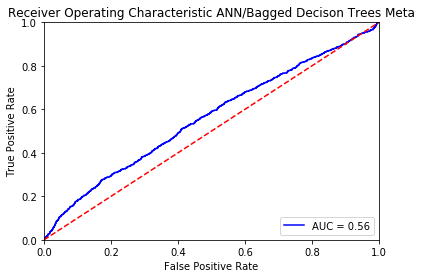

# Mean CV Score on Full Data Set 
(Metric: Accuracy)

In [374]:
scores = cvScore(bagged_dt_meta,full_new_x,full_new_y,sample_weights_meta,scoring='accuracy',
                 t1=vert_barr,cv=10,pctEmbargo=0.01)

In [375]:
scores.mean()

0.5410260995853677

# Performance and Risk Metrics

In [365]:
percentage_normalized_profit(new_y_test,new_x_test,labels_one,side,t1,bid,ask,filt)

0.30376569780317253

In [366]:
ANN_bag_ret = returns_series(new_x_test,side,t1,bid,ask,filt)

In [367]:
np.around(empyrical.stats.cum_returns(ANN_bag_ret).iloc[-1]*100, 2)

480.49

In [368]:
np.around(empyrical.stats.sharpe_ratio(ANN_bag_ret),2)

3.73

In [369]:
np.around(empyrical.stats.max_drawdown(ANN_bag_ret)*100,2)

-34.36

# Backtest

The SVM/Bagged Decision Tree model acheived the best performance out of the 3 models on the test dataset and will be backtested on 2011-2013 USD/JPY tick data. The exact same features as well as procedures that were used throughout this research will be used during backtesting.

Backtesting will be conducted using the cross-validation method. We will use 10 folds, giving us 10 different outcomes to compare. Backtesting using cross-validation has advantages over the traditional walk-forward method as we are not just evaluating our strategy using one scenario, but instead k scenarios. The purged k-fold class mentioned previously will be used to prevent data leakage. The cumulative returns, Sharpe Ratio, and max drawdown will be calculated for each fold and displayed in a DataFrame below. The code for the backtesting function used below can be found [here](https://github.com/JackBrady/Financial-Machine-Learning-Research/blob/master/Forex%20Research/Code/Backtest.py). Please note this function is not very elegant as it essentially runs all the previous code at each iteration/fold.

In [ ]:
backtest_df = backtest_cv('FILE_PATH')

In [412]:
backtest_df

,cum_returns,sharpe_ratio,max_drawdown
1,-22.13,-1.67,-40.37
2,-36.03,-5.80,-48.99
3,43.34,6.94,-4.69
4,139.06,4.10,-25.16
5,568.77,5.17,-28.92
6,-58.46,-4.75,-63.25
7,41.16,2.17,-19.84
8,-15.36,-1.28,-31.03
9,-40.68,-2.08,-69.09
10,-62.85,-3.54,-73.97


# Future Improvements

As can be seen from the initial backtest, results are very inconsistent and performance did not live up to the results achieved on the test set. This research is still a work in progress and many improvements will be made moving forward. These improvements will include:

More diversity in currencies. As stated previously, strategies will be developed for a more diverse subset of currencies opposed to just focusing on an individual currency.

Additionally, better feature engineering will be a focal point of future research. More unique features will be researched and tested, and additional feature selection methods will be employed.

As was previously mentioned, bet sizing will be incorporated into every bet taken by the secondary model using the predicted probabilities.

Also, different model types will be explored. Model stacking will be revisited and researched further. Additionally, various recurrent neural network architectures will be tested as models such as LSTMs have shown promise in time series forecasting. Finally, reinforcement learning will be explored as I have come across many papers showing the utility in using RL in finance. Here are two examples in the Forex market: 

Carapuço [2018] [link](https://www.researchgate.net/publication/327936415_Reinforcement_learning_applied_to_Forex_trading)
<br>
Huang [2018] [link](https://arxiv.org/pdf/1807.02787.pdf)


There are many opportunites for improvement that I did not mention, and many I'm sure that I do not realize, so any suggestion or criticism is welcome.

# References

Abreu, Gonçalo & Neves, Rui & Horta, Nuno. (2018). Currency exchange prediction using machine learning, genetic algorithms and technical analysis. 

Baasher, Areej & Fakhr, Mohamed. (2011). Forex trend classification using machine learning techniques. Proceedings of the 11th WSEAS International Conference on Applied Computer Science. 41-47.

Carapuço, João & Neves, Rui & Horta, Nuno. (2018). Reinforcement learning applied to Forex trading. Applied Soft Computing. 73. 10.1016/j.asoc.2018.09.017. 

J. Heaton, S. McElwee, J. Fraley and J. Cannady, "Early stabilizing feature importance for TensorFlow deep neural networks," 2017 International Joint Conference on Neural Networks (IJCNN), Anchorage, AK, 2017, pp. 4618-4624.

Yi Huang, Chien. (2018). Financial Trading as a Game: A Deep Reinforcement Learning Approach. 

Chin-Sheng Huang & Yi-Sheng Liu, 2019. "Machine Learning on Stock Price Movement Forecast: The Sample of the Taiwan Stock Exchange," International Journal of Economics and Financial Issues, Econjournals, vol. 9(2), pages 189-201.

López de Prado, Marcos, Advances in Financial Machine Learning. Advances in Financial Machine Learning, Wiley, 1st Edition (2018); ISBN: 978-1-119-48208-6.

Shahbazi, Nima & Memarzadeh, Masoud & Gryz, Jarek. (2016). Forex Market Prediction Using NARX Neural Network with Bagging. MATEC Web of Conferences. 68. 19001. 10.1051/matecconf/20166819001. 